In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import CLIPProcessor, CLIPModel
from torchvision.datasets import ImageFolder, DatasetFolder
from torchvision import transforms
from sklearn.metrics import accuracy_score
from PIL import Image
import clip

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# CLIP
VISUAL_BACKBONE = 'ViT-B/16' # RN50, ViT-B/32, ViT-B/16 ……
model, processor = clip.load(name=VISUAL_BACKBONE, device=device, download_root='/shareddata/clip/')
model.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [3]:
def preprocess_text(labels):
    max_length = 77
    processed_texts = []

    for label in labels.tolist():
    
        ascii_list = [ord(char) for char in str(label)]

        
        if len(ascii_list) < max_length:
            padded_text = ascii_list + [0] * (max_length - len(ascii_list))
            processed_texts.append(padded_text)
    
        elif len(ascii_list) >= max_length:
            truncated_text = ascii_list[:max_length]
            processed_texts.append(truncated_text)

    return processed_texts

In [4]:
import random
from torch.utils.data.sampler import SubsetRandomSampler

dataset_path = "images/Images"
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
dataset = ImageFolder(root=dataset_path, transform=transform)

batch_size = 128
num_iterations = 100
all_predictions = []
all_true_labels = []
accuracies = []
for iteration in range(num_iterations):
   
    indices = list(range(len(dataset)))
    random.shuffle(indices)

    selected_indices = indices[:batch_size]

    selected_sampler = SubsetRandomSampler(selected_indices)
    selected_loader = DataLoader(dataset, batch_size=batch_size, sampler=selected_sampler)

    with torch.no_grad():
        for images, labels in selected_loader:
            # Assuming your model accepts image inputs and text inputs
            image_inputs = images.to(device)

            processed_text_data = preprocess_text(labels)
            text_inputs = torch.tensor(processed_text_data, dtype=torch.long).to(device)

            outputs = model(image_inputs, text=text_inputs)

            image_features = outputs[0] 

            linear_classifier = torch.nn.Linear(image_features.shape[-1], len(dataset.classes)).to(device)
            image_features = image_features.to(linear_classifier.weight.dtype)
            logits = linear_classifier(image_features)

            # 对 logits 进行 softmax，获取分类概率
            probs = torch.nn.functional.softmax(logits, dim=-1)

            predictions = torch.argmax(probs, dim=-1).tolist()

            all_predictions.extend(predictions)
            all_true_labels.extend(labels.tolist())
            iteration_accuracy = accuracy_score(all_true_labels, all_predictions)
            print(iteration)
            print(iteration_accuracy)

            accuracies.append(iteration_accuracy)


0
0.0390625
1
0.0234375
2
0.018229166666666668
3
0.015625
4
0.015625
5
0.014322916666666666
6
0.012276785714285714
7
0.01171875
8
0.012152777777777778
9
0.0109375
10
0.01065340909090909
11
0.009765625
12
0.009615384615384616
13
0.008928571428571428
14
0.008333333333333333
15
0.00830078125
16
0.008731617647058824
17
0.008246527777777778
18
0.008223684210526315
19
0.00859375
20
0.00855654761904762
21
0.00887784090909091
22
0.008491847826086956
23
0.008463541666666666
24
0.0084375
25
0.00811298076923077
26
0.0078125
27
0.0078125
28
0.008081896551724138
29
0.0078125
30
0.008064516129032258
31
0.0078125
32
0.007575757575757576
33
0.007352941176470588
34
0.007366071428571428
35
0.007595486111111111
36
0.007390202702702703
37
0.0078125
38
0.0078125
39
0.0078125
40
0.007621951219512195
41
0.007998511904761904
42
0.007994186046511628
43
0.007990056818181818
44
0.0078125
45
0.0078125
46
0.007646276595744681
47
0.007649739583333333
48
0.007971938775510204
49
0.0078125
50
0.007659313725490196
51
0

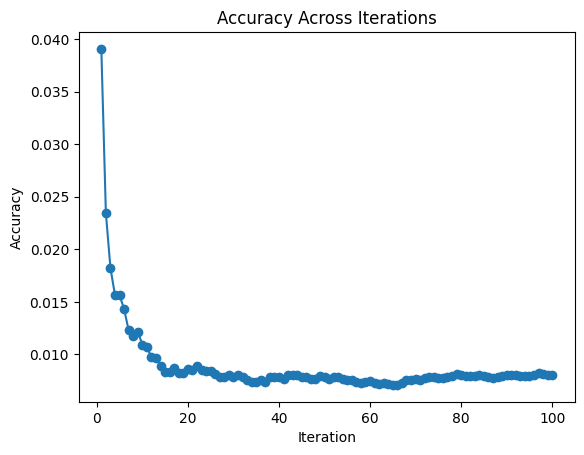

In [5]:
import matplotlib.pyplot as plt
plt.plot(range(1, num_iterations + 1), accuracies, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy Across Iterations')
plt.show()